In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
# sudo apt-get install texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra
fontsize=25

def replace_graph_names(df):
    df["Input Graph"] = df["Input Graph"].str.replace("com-", "", regex=True)\
                                    .str.replace(".gbbs.txt", "", regex=True)\
                                    .str.replace(".bin", "", regex=True)\
                                    .str.replace(".ungraph.txt", "", regex=True)\
                                    .str.replace(".graph.txt", "", regex=True)

def set_face_grid_ax_ticks(g):
    """Set fontsize for x and y axis ticks for all axes in a FacetGrid."""
    for ax in g.axes.flat:
        set_ax_ticks(ax)


def set_ax_ticks(ax):
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(fontsize)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(fontsize)
        
def common_ax_style(ax):
    ax.set_xticks([1, 4, 8, 16, 30, 60])
    ax.set_xticklabels([1, 4, 8, 16, 30, "30h"])
    
    ax.set_yscale('log')
    # plt.yticks([0.03, 0.1, 0.3, 1])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    set_ax_ticks(ax)
        
    ax.set_xlabel("Threads", fontsize = fontsize)

def plot_data(df, ax):
    sns.lineplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", linewidth = 3, ax = ax)
    sns.scatterplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", s = 30, ax = ax, legend=False)

def get_larger_handles(g, marker_size, ncol):
    g.add_legend(loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.15), fontsize=fontsize)
    if g._legend:
        for leg_handle in g._legend.legendHandles:
            leg_handle._sizes = [marker_size]

# Function to extract epsilon value from the config
def extract_epsilon(config):
    parts = config.split(',')
    for part in parts:
        if 'epsilon' in part:
            return part.split(':')[-1].strip()
    return None

def postpend_epsilon(df):
    df.loc[:, 'Clusterer Name'] = df.apply(lambda row: f"{row['Clusterer Name']}_{extract_epsilon(row['Config'])}", axis=1)

def add_epsilon_to_hac(df, remove_zero_eps = True):
    df_no_parhac = df[df["Clusterer Name"] != "ParHacClusterer"]
    df_parhac = df[df["Clusterer Name"] == "ParHacClusterer"]

    # split parhac to different methods for different epsilon
    postpend_epsilon(df_parhac)
    
    if remove_zero_eps:
        df_parhac = df_parhac[df_parhac["Clusterer Name"] != "ParHacClusterer_0"]

    df_new = pd.concat([df_no_parhac, df_parhac])
    
    return df_new

def remove_small_f1_methods(df):
    # filter out methods that can achieve > 0.5 * max f1 score
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        df_graph = df[df["Input Graph"] == graph]
        max_f1 = df_graph["fScore_mean"].max()
        print(graph, max_f1)
        df_graph_filtered = df_graph[df_graph["fScore_mean"] > 0.5 * max_f1]
        methods = df_graph_filtered["Clusterer Name"].unique()
        df_graph = df_graph[df_graph["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df

In [2]:
base_addr = "/Users/sy/Desktop/MIT/clusterer/csv/"

In [38]:
df = pd.read_csv(base_addr + "stats_rmat.csv")

In [39]:
clusterers = df["Clusterer Name"].unique()
cmap = plt.cm.tab20

# Ensure there are enough colors for the values
assert len(clusterers) <= cmap.N, "Not enough colors in the colormap for the clusterer values"

colors = [cmap(i) for i in range(len(clusterers))]

color_map = dict(zip(clusterers, colors))

# Define a list of marker styles
marker_styles = ['o', 's', '^', 'P', 'd', 'X', 'v', '<', '>', '*', '*', '*', '*', '*', 'D']

# Ensure there are enough markers for the clusterer values
assert len(clusterers) <= len(marker_styles), "Not enough marker styles for the clusterer values"

# Create a style_map that maps each value in clusterer values to a marker style
style_map = dict(zip(clusterers, marker_styles))


In [40]:
df.columns

Index(['Unnamed: 0', 'Clusterer Name', 'Input Graph', 'Threads', 'Config',
       'Round', 'Cluster Time', 'filename', 'numberNodes', 'numberClusters',
       'clusterSizes_minimum', 'clusterSizes_maximum', 'clusterSizes_mean',
       'clusterSizes_total', 'clusterSizes_count', 'correlationObjective',
       'modularityObjective', 'edgeDensity_minimum', 'edgeDensity_maximum',
       'edgeDensity_mean', 'edgeDensity_total', 'edgeDensity_count',
       'triangleDensity_minimum', 'triangleDensity_maximum',
       'triangleDensity_mean', 'triangleDensity_total',
       'triangleDensity_count', 'weightedEdgeDensityMean',
       'weightedTriangleDensityMean', 'Ground Truth'],
      dtype='object')

In [46]:
def plot_edge_density(df, x_axis, y_axis):
    plt.rcParams.update({'font.size': 14})

    # Create subplots in a 2x3 grid
#     fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

    graph_idx = 0

    lines = []  # To store the Line2D objects for the legend
    labels = []  # To store the corresponding labels for the Line2D objects
    graphs = df["Input Graph"].unique()
    for i in range(1):
        for j in range(4):
            if graph_idx < len(graphs):  # Ensure we have a graph to process
                graph = graphs[graph_idx]
#                 ax = axes[i][j]
                ax = axes[j]

                for clusterer in clusterers:
                    # Extract the pareto_df for the current graph and clusterer combination
                    pareto_df = df[(df["Input Graph"]==graph) & (df["Clusterer Name"]==clusterer)]
                    if pareto_df.empty:
    #                         print(graph, clusterer)
                        continue

                    # Plot the pareto_df with the appropriate marker
                    line, = ax.plot(pareto_df[x_axis], pareto_df[y_axis], label=clusterer, 
                                    color=color_map[clusterer], marker=style_map[clusterer], markersize=16, linewidth=2)

                    shortened_clusterer = clusterer.replace("Clusterer", "")
                    # If the clusterer's line hasn't been added to lines, add it
                    if shortened_clusterer not in labels:
                        lines.append(line)
                        labels.append(shortened_clusterer)
                
                n = graph.split("_")[1]
                m = graph.split("_")[2]
                
                ax.set_title(f"rmat n={n}, m={m}")
                ax.set_xlabel(x_axis)
                ax.set_ylabel(y_axis)

                graph_idx += 1
            else:
                axes[i][j].axis('off')  # Turn off axes without data


    # Create a single legend for the entire figure, at the top
    fig.legend(lines, labels, loc='upper center', ncol=7, bbox_to_anchor=(0.5, 1.1))

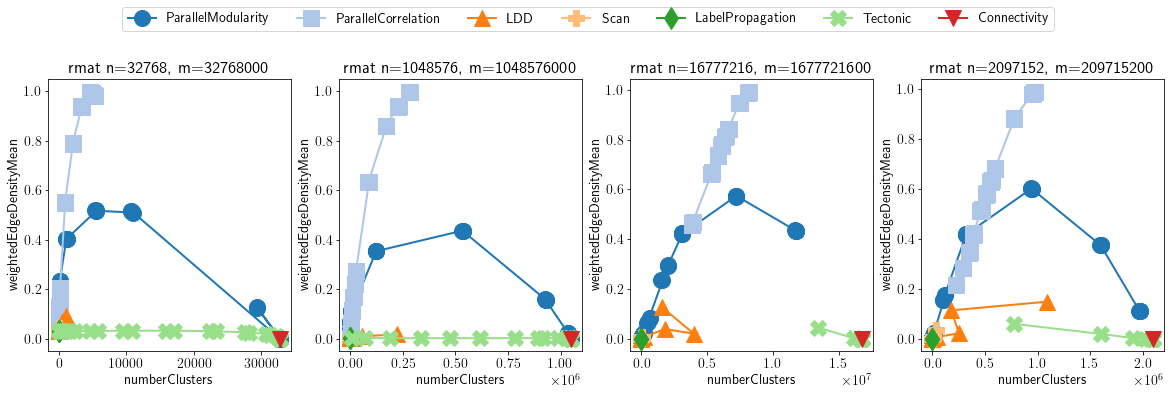

In [47]:
x_axis = "numberClusters"
y_axis = "weightedEdgeDensityMean"
plot_edge_density(df, x_axis, y_axis)

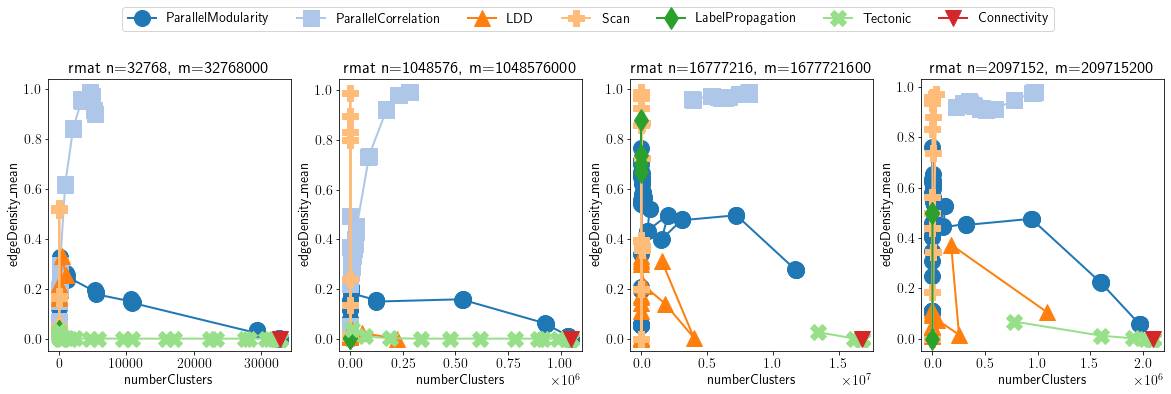

In [48]:
x_axis = "numberClusters"
y_axis = "edgeDensity_mean"
plot_edge_density(df, x_axis, y_axis)

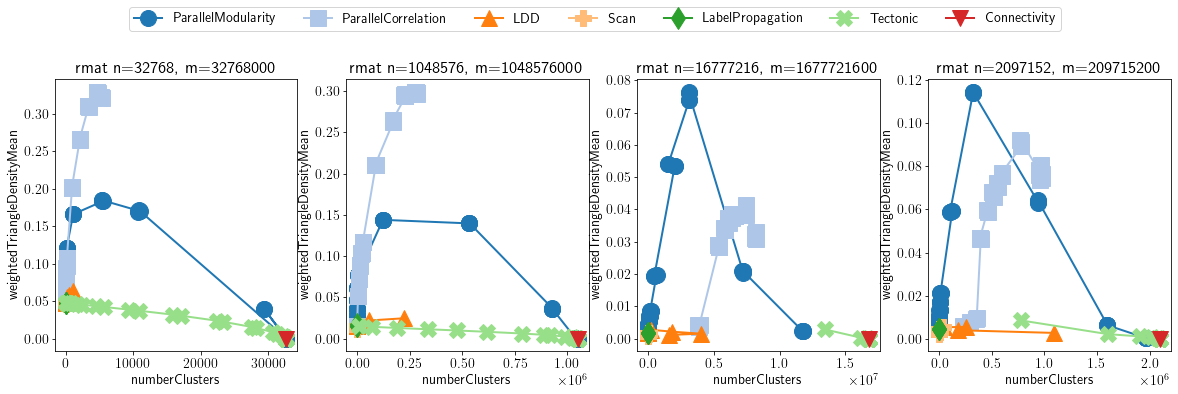

In [49]:
x_axis = "numberClusters"
y_axis = "weightedTriangleDensityMean"
plot_edge_density(df, x_axis, y_axis)

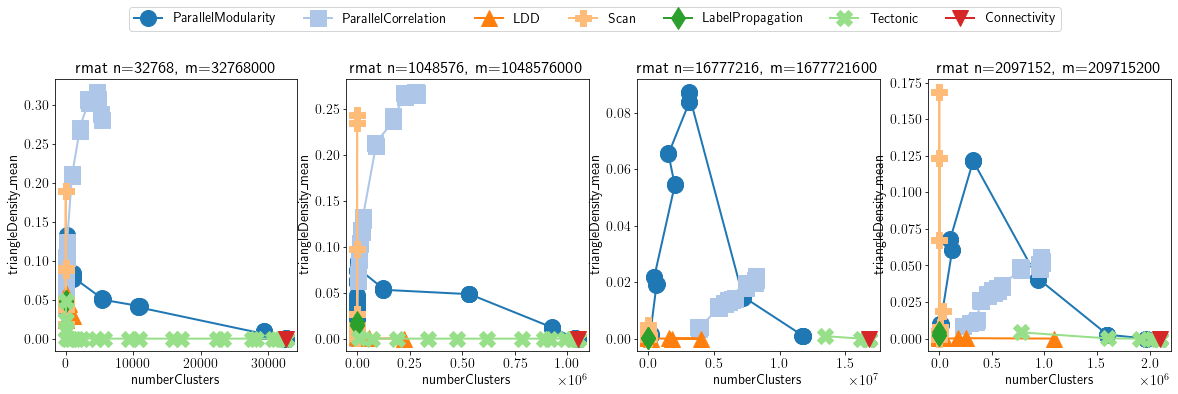

In [50]:
x_axis = "numberClusters"
y_axis = "triangleDensity_mean"
plot_edge_density(df, x_axis, y_axis)